In [1]:
!pip install langsmith
!pip install langchain
!pip install langgraph
!pip install faiss-cpu
!pip install langchain-hub
!pip install langchain_groq
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 50.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement langchain-hub (from versions: none)
ERROR: No matching distribution found for langchain-hub
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.7/409.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.21
    Uninstalling langchain-core-0.3.21:
      Successfully uninstalled langchain-core-0.3.21
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.9
    Uninstalling langch

In [29]:
!pip install arxiv wikipedia langchain_community

In [39]:
wikipedia_tool.name,arxiv_tool.name

('wikipedia', 'arxiv')

In [2]:
import os
from google.colab import userdata
lamgsmith=userdata.get('LANG_CHAIN_SMITH')
groq_api = userdata.get('groq_api_key')

In [7]:
#validate all the keys
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = lamgsmith
os.environ["LANGCHAIN_PROJECT"] = "langchain"

In [44]:
import langchain,langgraph,langchain_groq,langchain_community
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from typing import TypedDict      #this is used for managing state class
from typing_extensions import Annotated      #this is used for managing state class
from langchain.memory import VectorStoreRetrieverMemory,ConversationBufferWindowMemory,ConversationBufferMemory
from langchain_groq import ChatGroq
from pydantic import BaseModel
from pydantic.v1 import Field

In [42]:
#creating object of llm model
llm = ChatGroq(
    groq_api_key=groq_api,
    model="gemma-7b-it",
    verbose=True,
)

In [25]:
response = llm.invoke("Most difficult word in medical to read in the world?")
print(response.content)

**Hypopalatine**

This word is considered one of the most difficult words in the medical field due to its complex structure, numerous syllables, and unusual spelling.


In [41]:
#install  external tools like wipediaapiwrapper,Arxivapiwrapper
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

#Arxiv and wikipidia
arxiv_api = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=500)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_api) #for arxiv tools these are external tools

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=400)
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper) #for wikipedia tool these are external tools

print(F"TOOLS ARE: {arxiv_tool.name} and {wikipedia_tool.name}")

TOOLS ARE: arxiv and wikipedia


In [48]:
wikipedia_tool.invoke("Most difficult word in medical to read in the world?").split("\n")

['Page: Reading',
 'Summary: Reading is the process of taking in the sense or meaning of symbols, often specifically those of a written language, by means of sight or touch.',
 'For educators and researchers, reading is a multifaceted process involving such areas as word recognition, orthography (spelling), alphabetics, phonics, phonemic awareness, vocabulary, comprehension, fluency, and motivation.',
 'Other t']

In [52]:
arxiv_tool.invoke("Attention is all you need").split("\n")

['Published: 2024-07-22',
 "Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models",
 'Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini',
 'Summary: The inference demand for LLMs has skyrocketed in recent months, and serving',
 'models with low latencies remains challenging due to the quadratic input length',
 'complexity of the attention layers. In this work, we investigate the effect of',
 'dropping MLP and attention layers at inference time o']

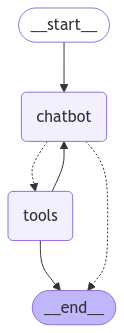

In [64]:
#1:Langraph_application
from langgraph.prebuilt import ToolNode,tools_condition

class State(TypedDict):
  messages : Annotated[list,add_messages]  #append this message in the form of list

graph_builder = StateGraph(State)

#2: bind llm with the tools
llm_with_tools=llm.bind_tools(tools=[arxiv_tool,wikipedia_tool])


#3: define our chatbot
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

#entire flow of the execution
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot") #start node is connected with chabot
tool_node=ToolNode(tools=[arxiv_tool,wikipedia_tool])
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition  #bidirection itself with the chatbot
)
graph_builder.add_edge("tools","chatbot") #tools node is connected with chatbot
graph_builder.add_edge("tools",END) #end node is connected with tools

graph_built = graph_builder.compile()


from IPython.display import Image,display

try:
  display(Image(graph_built.get_graph().draw_mermaid_png()))
except:
  "you may have some error"

In [85]:
user_input = "write a c++ code to built a calcualtor?"

events = graph_built.stream(
    {"messages" : [("user" , user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

write a c++ code to built a calcualtor?
================================== Ai Message ==================================

```c++
#include <iostream>
#include <string>

using namespace std;

int main() {
  string operator;
  float num1, num2;

  cout << "Enter the first number: ";
  cin >> num1;
  cout << "Enter the operator (+ - * /): ";
  cin >> operator;
  cout << "Enter the second number: ";
  cin >> num2;

  float result;

  switch (operator[0]) {
    case '+' :
      result = num1 + num2;
      break;
    case '-' :
      result = num1 - num2;
      break;
    case '*' :
      result = num1 * num2;
      break;
    case '/' :
      if (num2 == 0) {
        cout << "Division by zero is undefined." << endl;
        return 1;
      }
      result = num1 / num2;
      break;
    default:
      cout << "Invalid operator." << endl;
      return 1;
  }

  cout << "The result is: " << result << endl;

  retu